# Fitting a Maxwellian Distribution curve to histogram generated from velocity distribution generated by collision of 4 balls confined in a chamber

In [1]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
def Maxwell(v):
    return v*np.exp(-0.5*v**2)


#####  Function to compute time for wall collision ######
def wall_time(coord, velcomp, rad):  
    if velcomp > 0.0:
        del_t = (1.0 - rad - coord) / velcomp
    elif velcomp < 0.0:
        del_t = (coord - rad) / abs(velcomp)
    else:
        del_t = float('inf')
    return del_t


# Function to calculate time it takes for a pair of particles to collide. 
# pos1 and pos2 are positions of particles 1 and 2, vel1 and vel2 are their 
# velocities. rad is the radius of the particles. 
def pair_time(pos1, vel1, pos2, vel2, rad):  
    rel_pos = pos2 - pos1
    rel_vel = vel2 - vel1
    rel_dist_squar = np.dot(rel_pos,rel_pos)
    rel_speed_squar = np.dot(rel_vel,rel_vel)
    scal_prod = np.dot(rel_pos,rel_vel)
    a = scal_prod ** 2 - rel_speed_squar * ( rel_dist_squar - 4.0 * rad **2)
    if a > 0.0 and scal_prod < 0.0: ## Conditions for collision.
        del_t = - (scal_prod + np.sqrt(a)) / rel_speed_squar ## Collision time.
    else:
        del_t = float('inf')
    return del_t


# Function to generate an image of the disk configuration in the box.
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)
        saver = tf.train.saver()  
        saver.save(session, CHECKPOINT_PATH) 

In [3]:
######################### Initialization #################################
L = 1. ## Box edge length
Natoms = 4  # Number of disks
density = 0.2 # Fraction of the area of the box covered by the disks
Ratom = np.sqrt(density/(Natoms*np.pi))   ## Radius of disk.
histo_data = []


## List indexing all pairs of atoms.
pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 

## Positions and velocities of disks.
positions = np.array([[0.4,0.4],[0.4,0.6],[0.6, 0.4], [0.6,0.6]])
velocities = np.array([[np.sqrt(2),0.],[1.,1.],[0.,np.sqrt(2)],[np.sqrt(0.5),np.sqrt(1.5)]])

t = 0.0 # Initial time.
n_events = 2000000 # Number of collision events.
#################################################################################

In [4]:
 ############### Event Loop ##############################################
for event in range(n_events):
    # Wall collision times for all disks and their velocity components.
    wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)] 
    # Pair collision times
    pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
    # The next collision event is the minimum of wall and pair collision times.
    next_event = min(wall_times + pair_times)  
    t_previous = t
    for inter_times in range(int(t+1), int(t+next_event+1)):
        del_t = inter_times - t_previous
        positions += velocities * del_t
        t_previous = inter_times
        for k in range(Natoms):
            histo_data.append(np.sqrt(velocities[k][0]**2 + velocities[k][1]**2))
    t += next_event
    positions += velocities * (t-t_previous)
    if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall
        wall_index = wall_times.index(next_event)
        particle, component = divmod(wall_index, 2)
        velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
    else:
        pair_index = pair_times.index(next_event)
        particle_1, particle_2 = pairs[pair_index] # Indices of particles participating in collision.
        rel_pos = positions[particle_2] - positions[particle_1]
        rel_vel = velocities[particle_2] - velocities[particle_1]
        distance = np.sqrt(np.dot(rel_pos,rel_pos))
        unit_perp = rel_pos/distance
        scal_prod = np.dot(rel_vel,unit_perp)
        velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
        velocities[particle_2] -= scal_prod*unit_perp
    #print( sum([np.dot(velocities[i],velocities[i]) for i in range(len(velocities))]))

##################################################################################


Text(0, 0.5, 'P(u)')

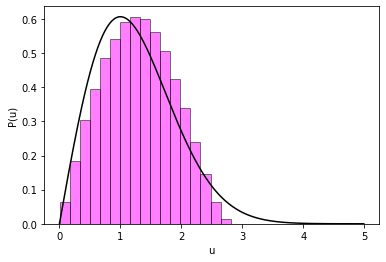

In [5]:
test_speeds = np.arange(0., 5., 0.01)
plt.plot(test_speeds, Maxwell(test_speeds), 'k-')

speeds = np.array(histo_data)
plt.hist(speeds, 17, density = True, facecolor='fuchsia', edgecolor='k', alpha = 0.5)
plt.xlabel('u')
plt.ylabel('P(u)')